In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import os
from ast import literal_eval
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import pickle
import networkx as nx
from ceres_infer.analyses import *
from os import listdir
import pickle
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
# from ceres_infer.data import stats_Crispr, scale_data

In [2]:
### For reg_boruta, create y_compr_tr and te from individual model_perf file
def create_compr(boruta_dir):
    df_tr_actual = pd.DataFrame();df_tr_pred = pd.DataFrame()
    df_te_actual = pd.DataFrame();df_te_pred = pd.DataFrame()

    for f in listdir(boruta_dir):
        if f.startswith('y_compr_'): 
            gene = f.split('.')[0].split('_')[-1]
            y_compr_gene = pickle.load(open(os.path.join(boruta_dir,f),'rb'))
            df_tr_actual[gene] = y_compr_gene['tr']['y_actual']
            df_tr_pred[gene] = y_compr_gene['tr']['y_pred']
            df_te_actual[gene] = y_compr_gene['te']['y_actual']
            df_te_pred[gene] = y_compr_gene['te']['y_pred']

    y_compr_te_boruta = {'actual':df_te_actual,'predicted':df_te_pred}
    y_compr_tr_boruta = {'actual':df_tr_actual,'predicted':df_tr_pred}
    
    return y_compr_tr_boruta, y_compr_te_boruta

In [3]:
### Define a function calculate pearson correlation for all genes
def get_pearsonr(col):
    name = col.name
    corr = pearsonr(col,y_compr_te['predicted'][name])[0]
    return corr

In [4]:
### To double check, test r2 score too
def get_r2(col):
    name = col.name
    r2 = r2_score(col,y_compr_te['predicted'][name])
    return r2

In [25]:
### Open the compr folder
model_dirs = {'elasticnet': '../out/20.0819 modcompr/reg_elasticNet_infer/',
              'lm': '../out/20.0819 modcompr/reg_lm_infer/',
              'rf': '../out/20.0819 modcompr/reg_rf_infer/',
              'rf_boruta': '../out/20.0216 feat/reg_rf_boruta',
              'nn': None}
xlab_dict = {'elasticnet': 'elastic net',
              'lm': 'linear regression',
              'rf': 'random forest',
              'rf_boruta': 'random forest\niter select+boruta',
              'nn': 'nearest neighbors'} # xlabel dict mapping

In [27]:
scores_rd10 = pd.DataFrame()
scores_r2 = pd.DataFrame()
# Iterate through moddir to obtain y_compr prediction data
for model, model_dir in model_dirs.items():
    if model == 'rf_boruta':
        y_compr_tr, y_compr_te = create_compr(os.path.join(model_dir,'model_perf'))

    elif model != 'nn': 
        y_compr_tr = pickle.load(open(os.path.join(model_dir, 'anlyz', \
                                                   'y_compr_tr.pkl'), 'rb'))
        y_compr_te = pickle.load(open(os.path.join(model_dir, 'anlyz', \
                                                   'y_compr_te.pkl'), 'rb'))
        
    # Calculate pearson correlation between actual and predicted
    ser_corr = y_compr_te['actual'].apply(lambda x: get_pearsonr(x))
    ser_r2 = y_compr_te['actual'].apply(lambda x: get_r2(x))
    scores_rd10[model] = [ser_corr.median()]
    scores_r2[model] = [ser_r2.median()]

In [29]:
scores_r2

,elasticnet,lm,rf,rf_boruta,nn
0,0.100113,-0.024167,0.258551,0.386523,0.386523


In [30]:
### Get the nearest neighbor correlation plot 
df_prediction = pd.read_csv('prediction_040621.csv', index_col = 0)

dir_in_res = '../out/20.0216 feat/reg_rf_boruta'
q3_dir = '../data/DepMap/19Q3'
df_ref19q3 = pd.read_csv(os.path.join(q3_dir,'Achilles_gene_effect.csv'), index_col = 0)
dir_in_anlyz = os.path.join(dir_in_res, 'anlyz_filtered')
f_featsumm = os.path.join(dir_in_anlyz,'agg_summary_filtered.csv')
df_aggRes = pd.read_csv(f_featsumm) #aggregated feat summary
div_genes = df_aggRes['target']

### map the div_gene name to the name in prediction dataframe
list_div_genes = []
for gene_idx in df_prediction.columns:
    gene_name = gene_idx.split(' ')[0]
    if gene_name in div_genes.to_list():
        list_div_genes.append(gene_idx)
### Plot the correlation plot between actual and predicted, for every gene
df_corr_gene = pd.DataFrame(columns = ['gene','corr'])

list_corr = []
list_r2 = []
for gene in list_div_genes:
    df_score = pd.DataFrame(columns = ['actual','predicted'])
    df_score['actual'] = df_ref19q3.loc[:,gene]
    df_score['predicted'] = df_prediction.loc[:,gene]
    df_score = df_score.dropna()
    corr = pearsonr(df_score['actual'],df_score['predicted'])[0]
    list_corr.append(corr)
    score_r2 = r2_score(df_score['actual'],df_score['predicted'])
    list_r2.append(score_r2)
    
df_corr_gene['gene'] = div_genes; df_corr_gene['corr'] = list_corr;df_corr_gene['r2(score_test)'] = list_r2

In [31]:
scores_rd10['nn'] = df_corr_gene['corr'].median()
scores_r2['nn'] = df_corr_gene['r2(score_test)'].median()

In [32]:
scores_r2

,elasticnet,lm,rf,rf_boruta,nn
0,0.100113,-0.024167,0.258551,0.386523,-0.705778


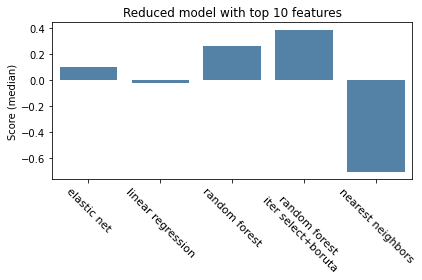

In [34]:
plt.figure()
ax = sns.barplot(scores_r2.columns, scores_r2.values[0], color='steelblue')
ax.set(ylabel='Score (median)', xlabel='', title='Reduced model with top 10 features')
ax.set_xticklabels([xlab_dict[n] for n in model_dirs.keys()], rotation=-45, size=11)
plt.tight_layout()
# plt.savefig("%s/fig1supp_compr_mod_rd10.pdf" % dir_out)
plt.show()
plt.close()

elasticnet
lm
rf
rf_boruta


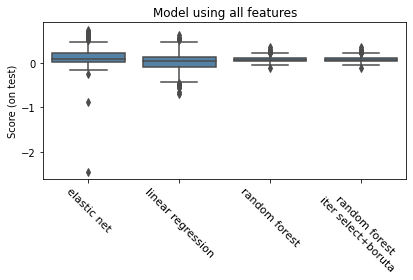

             full     reduced  reduced10feat
count  581.000000  581.000000     581.000000
mean     0.138418    0.138419       0.132926
std      0.187239    0.187239       0.220467
min     -2.455300   -2.455270      -3.703410
25%      0.037170    0.037170       0.035810
50%      0.107110    0.107110       0.100110
75%      0.221220    0.221210       0.216620
max      0.761660    0.761690       0.762620
             full     reduced  reduced10feat
count  583.000000  583.000000     583.000000
mean     0.030242    0.037119      -0.071210
std      0.182641    0.181812       1.180950
min     -0.688890   -0.623290     -17.472100
25%     -0.076855   -0.074915      -0.166655
50%      0.046780    0.053120      -0.024170
75%      0.149190    0.149070       0.345270
max      0.643560    0.658700       0.882980
             full     reduced  reduced10feat
count  583.000000  583.000000     583.000000
mean     0.086768    0.115086       0.285333
std      0.059469    0.077145       0.231283
min     -0

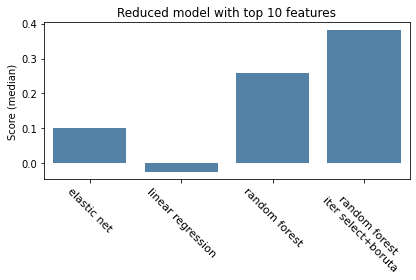

In [12]:
#-- comparison of different ML models
model_dirs = {'elasticnet': '../out/20.0819 modcompr/reg_elasticNet_infer/',
              'lm': '../out/20.0819 modcompr/reg_lm_infer/',
              'rf': '../out/20.0819 modcompr/reg_rf_infer/',
              'rf_boruta': '../out/20.0216 feat/reg_rf_boruta'}



# scores (test set), full model
scores = {}
for model, model_dir in model_dirs.items():
    print(model)
    res = pd.read_csv(os.path.join(model_dir, 'model_results.csv'))
    scores.update({model: res.loc[res.model == 'all', 'score_test'].values})
scores = pd.DataFrame.from_dict(scores)
df = pd.melt(scores)

plt.figure()
ax = sns.boxplot(data=df, x='variable', y='value', color='steelblue')
ax.set(ylabel='Score (on test)', xlabel='', title='Model using all features')
ax.set_xticklabels([xlab_dict[n] for n in model_dirs.keys()], rotation=-45, size=11)
plt.tight_layout()
# plt.savefig("%s/fig1supp_compr_mod_full.pdf" % dir_out)
plt.show()
plt.close()

# scores (median), reduced top10 feat models
scores_rd10 = {}
for model, model_dir in model_dirs.items():
    res = pd.read_csv(os.path.join(model_dir, 'anlyz/stats_score_aggRes/stats_score.csv'), index_col=0)
    print(res)
    scores_rd10.update({model: res.loc[res.index == '50%', 'reduced10feat'].values})
scores_rd10 = pd.DataFrame.from_dict(scores_rd10)

plt.figure()
ax = sns.barplot(scores_rd10.columns, scores_rd10.values[0], color='steelblue')
ax.set(ylabel='Score (median)', xlabel='', title='Reduced model with top 10 features')
ax.set_xticklabels([xlab_dict[n] for n in model_dirs.keys()], rotation=-45, size=11)
plt.tight_layout()
# plt.savefig("%s/fig1supp_compr_mod_rd10.pdf" % dir_out)
plt.show()
plt.close()